# Task 2 - Base skills.

Perform the following sequence of actions.
1. Open a terminal by clicking the the `Terminal` button on the bottom left of the screen.
2. Navigate to the root directory.
3. Create a directory called `my_repo`.
4. Navigate into the directory you have just created.
5. Start a git repo.
6. Create a file called `my_file.py` with the following content:
```python
def get_add_int(a):
    def add(b):
        return a + b
    return add

add_5 = get_add_int(5)
result = add_5(3)
print(result)
```
7. Install the python package `mypy` using pip.
8. Run mypy with the flag `--strict` on the file `my_file.py`.
9. Given the output of `mypy` fix the typing errors in the file and run `mypy` again to show that they are fixed.
10. Commit the file to the git repo.

Hint: you may have to import from the `typing` module to fix the typing errors.

Hint: If you can't use vim, you are welcome to use the file browser on the left.

## Before you start:
1. Disable AI assitance by clicking the settings cog in top right of the screen.
2. Enable GPU runtime by going to `Runtime -> Change runtime type`.

# Task 1 - CIFAR10 classifier.

The cells below implement a basic CIFAR10 classifier. However, they contain a number of bugs that make the training not work. Your tasks it to find and correct these bugs and ensure that the classifier trains properly. It is possible to achieve a performance of >70% test accuracy without major modifications.

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np



In [5]:
from torchvision.transforms import ToTensor

## Load the data.


In [26]:
def load_image(pil_image):
    #return transforms.functional.pil_to_tensor(pil_image)
    trans_class = ToTensor()
    transformed = trans_class(pil_image)
    return transformed

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=load_image)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=load_image)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

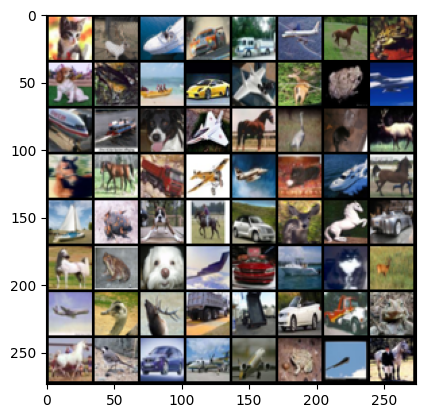

In [27]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

## Define a model architecture.

In [33]:
class Net(nn.Module):
    def __init__(self, num_features):
        super().__init__()

        self.net = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=num_features[0], kernel_size=3, padding='same'),

            nn.ReLU(),
            nn.InstanceNorm2d(num_features=num_features[0]),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=num_features[0], out_channels=num_features[1], kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.InstanceNorm2d(num_features=num_features[1]),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(in_features=(8*8)*num_features[1], out_features=40),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=40, out_features=10),
            nn.Softmax(dim=-1)
            )

        # 8 x8 = 64

        # 64 * 128


    def forward(self, x):
        return self.net(x)

net = Net(num_features=(32, 64, 128))
print(net)

Net(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=4096, out_features=40, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=40, out_features=10, bias=True)
    (13): Softmax(dim=-1)
  )
)


## Define validation epoch.

In [45]:
def val_epoch(testloader, net, criterion):

  correct, total = 0, 0
  running_loss = 0.0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)

          outputs = net(images)



          loss = criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          correct +=torch.sum(predicted == labels)


  accuracy = (correct/total)*100
  avg_loss = running_loss / len(testloader)
  return accuracy, avg_loss

## Training loop.



In [48]:
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)

epochs = 5

training_loss_history = []
val_loss_history = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()

    avg_epoch_loss = running_loss / len(trainloader)
    training_loss_history.append(avg_epoch_loss)
    val_accuracy, val_loss = val_epoch(testloader, net, criterion)
    val_loss_history.append(val_loss)
    print(f"Epoch {epoch + 1}, Train loss: {avg_epoch_loss:.4f},  Val loss: {val_loss:.4f}")
    print(f'Val accuracy on 10000 test images: {val_accuracy:.2f}%')

Epoch 1, Train loss: 2.3019,  Val loss: 2.2998
Val accuracy on 10000 test images: 11.62%
Epoch 2, Train loss: 2.2994,  Val loss: 2.2974
Val accuracy on 10000 test images: 12.26%
Epoch 3, Train loss: 2.2967,  Val loss: 2.2951
Val accuracy on 10000 test images: 12.97%
Epoch 4, Train loss: 2.2937,  Val loss: 2.2923
Val accuracy on 10000 test images: 13.79%
Epoch 5, Train loss: 2.2914,  Val loss: 2.2901
Val accuracy on 10000 test images: 14.71%


## Plot

What kind of behavior do you observe?

In [ ]:
def plot_loss_history(train_loss_history, val_loss_history):
    epochs = range(1, len(train_loss_history) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_history, label='Training Loss')
    plt.plot(epochs, val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_history(training_loss_history, val_loss_history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Task 2 - Base skills.

Perform the following sequence of actions.
1. Open a terminal by clicking the the `Terminal` button on the bottom left of the screen.
2. Navigate to the root directory.
3. Create a directory called `my_repo`.
4. Navigate into the directory you have just created.
5. Start a git repo.
6. Create a file called `my_file.py` with the following content:
```python
def get_add_int(a):
    def add(b):
        return a + b
    return add

add_5 = get_add_int(5)
result = add_5(3)
print(result)
```
7. Install the python package `mypy` using pip.
8. Run mypy with the flag `--strict` on the file `my_file.py`.
9. Given the output of `mypy` fix the typing errors in the file and run `mypy` again to show that they are fixed.
10. Commit the file to the git repo.

Hint: you may have to import from the `typing` module to fix the typing errors.

Hint: If you can't use vim, you are welcome to use the file browser on the left.

# Bonus Task.

Suppose for the previous example, you wanted to add any two objects of the same type, for example:

```python
def get_add_any(a):
    def add(b):
        return a + b
    return add

function = get_add_val(1)
value = function(1)  # mypy should pass

function = get_add_val("hello, ")
value = function("world")  # mypy should pass

function = get_add_val(1)
value = function("x")  # mypy should fail
```
How would you type the `get_add_any` function?